# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

Импортируем библиотеку и загрузим данные в датафрейм. Изучим первые 5 строк датафрейма, чтобы ознакомиться с данными.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Проверим структуру данных. Какие есть столбцы, какой тип данных в них и есть ли пропущенные значения.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Всего 23699 строк и 21 столбец. В столбцах много пропущенных значений. Постоим гистограмму для всех числовых столбцов.

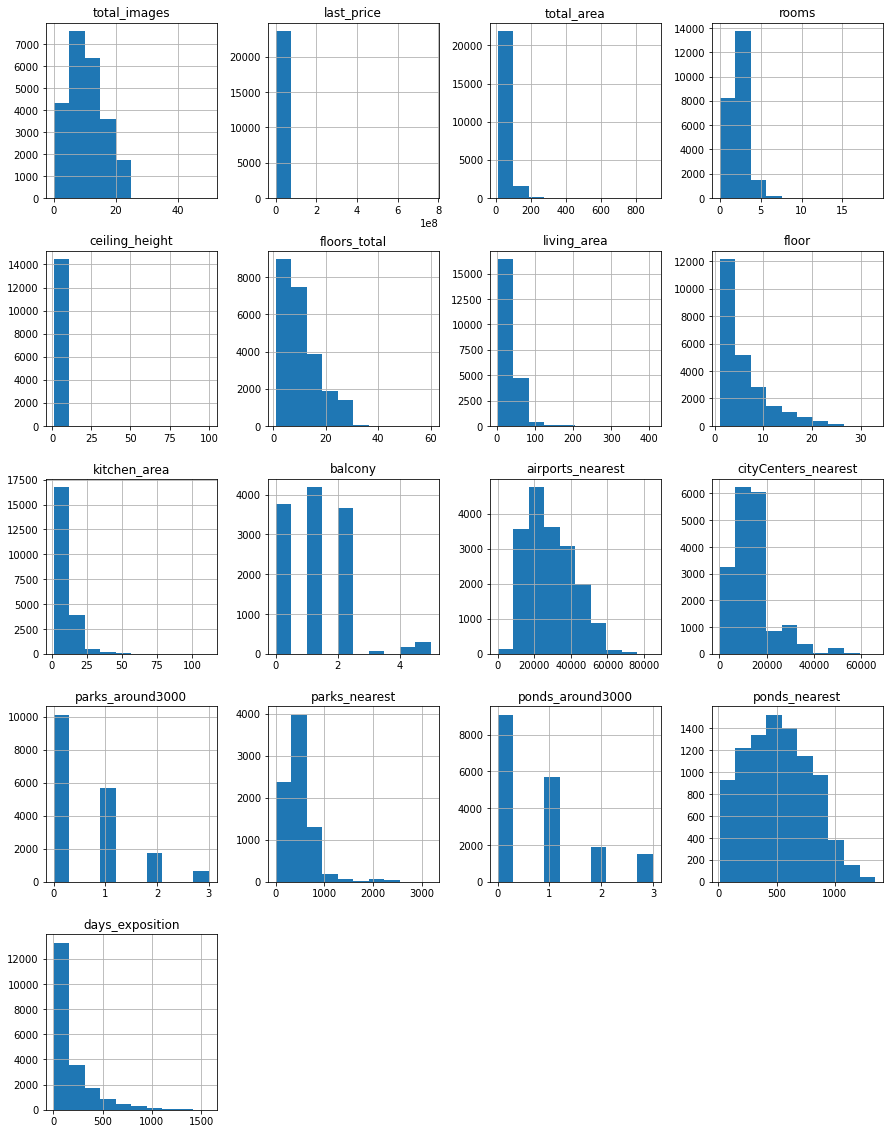

In [4]:
data.hist(figsize=(15, 20))
plt.show()

#### Вывод

Много пропусков, особенно в данных полученных автоматически. Многие распределения имеют скос вправо. Еще есть выбросы, которые надо будет рассмотреть лучше. 

### Выполните предобработку данных

Для начала посмотрим пропущенные значения более детально.

In [5]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Рассмотрим поближе данные из столбца "Высота потолков". Выведем все уникальные значения (с сортировкой по возрастанию), чтобы посмотреть данные:

In [6]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Вот мы и нашли анамальную высоту потолка, а так же несколько нестандартных, т.к. они повлияет на рассчет средней высоты, возьмем и заполним пустые значения медианой.

In [7]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].sort_values().unique() #проверим что в итоге получилось

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Тип числа с плавающей точкой, это нормально для высоты потолков. Тип данных менять не нужно.

Посмотрим далее "Этажность дома", по ним нам негде взять данные.

In [8]:
data['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60., nan])

Жилая площадь - заполнить не получится, так как у нас не хватает данных об других зонах, например, ванная комната или туалет, а также корридор. Тип данных менять не нужно.

Аппартаменты - предполагаю, что если данное поле не заполнено, то объект не относится к аппартаментам. Посмотрим на данные:

In [9]:
data['is_apartment'].sort_values().unique()

array([False, True, nan], dtype=object)

Заменим пропущенные значения на "False" и сменим тип на Boolean.

In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False) # Заполняем
data['is_apartment'].unique() # Проверим что получилось

array([False,  True])

In [11]:
# код ревьюера

bool('False')

True

Площадь кухни. Тоже не сможем заполнить.

Столбец "Балкон". Предполагаю что если данные по балкону отсутствуют, то значение у них 0. Заполним пропущенные значения нулями. 

Также количество балконов может быть только целочисленными значениями, поэтому сразу переведем даные из столба в тип int.

In [12]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype(int) #количество балконов может быть только целым числом, преобразуем в нужный тип
data['balcony'].sort_values().unique() #проверяем данные в столбке "балкон" после обработки

array([0, 1, 2, 3, 4, 5])

Посмотрим что получилось срезу данных, которые заполняли пользователи:

In [13]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Далее будем рассматривать данные полученные автоматически.

Первый столбец на очереди "Название населенного пункта". Мы не можем предполагать какой населенный пункт у того или другого объекта. Есть часть где можно сопоставить удаленность от аэропорта и остальные геоданные на совпадение, но это не очень достоверно. Поэтому заполним данные как "unknown".

In [14]:
data['locality_name'] = data['locality_name'].fillna('unknown')

Разберем неявные дубликаты. Есть буквы "е" и "ё" заменим все на "е".

In [15]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [16]:
data['locality_name'].sort_values().unique()

array(['unknown', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск',
       'Выборг', 'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород',
       'Каменногорск', 'Кингисепп', 'Кириши', 'Кировск', 'Колпино',
       'Коммунар', 'Красное Село', 'Кронштадт', 'Кудрово',
       'Лодейное Поле', 'Ломоносов', 'Луга', 'Любань', 'Мурино',
       'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф',
       'Пикалево', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин',
       'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сестрорецк',
       'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно',
       'Шлиссельбург', 'городской поселок Большая Ижора',
       'городской поселок Будогощь', 'городской поселок Виллози',
       'городской поселок Лесогорский', 'городской поселок Мга',
       'городской поселок Назия', 'городской поселок Новоселье',
       'городской поселок Павлово', 'городской поселок Рощино',
       'городской поселок Свирьстрой', 'городской поселок Советский',
       'гор

Для поиска неявных дубликатов удалим общие слова и добавим их в новый столбец. Убираем: "городской", "поселок, "деревня", "коттеджный", "городского типа", "при железнодорожной", "станции", "садовое", "товарищество", "садоводческое", "некоммерческое", "село".

In [17]:
data['locality_name_clean'] = (
    data['locality_name']
    .replace(['городской', 'поселок', 'деревня', 'коттеджный', 'городского типа', 'при железнодорожной', 'станции', 'садовое', 'товарищество', 'садоводческое', 'некоммерческое', 'село'],  '', regex=True)
    .str.strip()
)

In [18]:
data['locality_name_clean'].sort_values().unique()

array(['unknown', 'Агалатово', 'Александровская', 'Алексеевка', 'Аннино',
       'Аро', 'Барышево', 'Батово', 'Бегуницы', 'Белогорка', 'Белоостров',
       'Бокситогорск', 'Большая Вруда', 'Большая Ижора',
       'Большая Пустомержа', 'Большие Колпаны', 'Большое Рейзино',
       'Большой Сабск', 'Бор', 'Борисова Грива', 'Бугры', 'Будогощь',
       'Ваганово', 'Важины', 'Вартемяги', 'Вахнова Кара', 'Вещево',
       'Виллози', 'Вознесенье', 'Возрождение', 'Войсковицы', 'Войскорово',
       'Володарское', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Вырица', 'Выскатка', 'Высокоключевой', 'Высоцк', 'Гаврилово',
       'Гарболово', 'Гатчина', 'Гладкое', 'Глажево', 'Глебычево',
       'Глинка', 'Гончарово', 'Горбунки', 'Гостилицы', 'Громово',
       'Дзержинского', 'Дружная Горка', 'Дружноселье', 'Дубровка',
       'Елизаветино', 'Ефимовский', 'Жил', 'Жилгородок', 'Житково',
       'Заводской', 'Заклинье', 'Заневка', 'Запорожское', 'Зеленогорск',
       'Зимитицы', 'Ивангород', 'Изв

Сверим кол-во уникальных значений в столбцах до и после обработки.

In [19]:
print(data['locality_name'].nunique())
data['locality_name_clean'].nunique()

331


306

In [20]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
locality_name_clean         0
dtype: int64

Остальные (не рассмотренные) данные собраны автоматически, однако, мы не можем предугадать данные.

Посмотрим снова на информацию по столбцам и допроверим остальные типы.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  int64  
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [22]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_clean
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,Санкт-Петербург
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,Шушары
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,Санкт-Петербург
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,False,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,Санкт-Петербург
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,Санкт-Петербург


Приведем столбец "first_day_exposition" и "last_price" к правильному формату.

In [23]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['last_price'] = data['last_price'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Вывод
##### Пропуски значений

Пропуски в данных, собранных от людей, скорее всего, из-за того, что поля не обязательны или у пользователей нет данных. Что касаемо данных «Аппартаменты» и подобных, то, скорее всего, не заполнено, потому что пользователи посчитали, если не является аппартаментами, то и заполнять данное поле не обязательно.

Пропуски в данных, собранных автоматически, подозрительно совпадают, скорее всего, не удалось распознать расположение.

Конечно, никогда не исключаем технические ошибки при сборе данных.

##### Типы данных в столбцах

Были изменены типы данных, такие как время (first_day_exposition), для дальнейшего анализа нам нужно будет «вытягивать» данные, например, по месяцу. Были переведены в целочисленный тип там, где не может быть итого, например, «Этажность дома». Еще изменен тип на булево значение в столбце «Аппартаменты», т.к. значения «True»/«False» и их удобно будет использовать в дальнейшем анализе.

##### Неявные дубликаты

Данные взяты только по Санкт-Петербургу и соседних населённых пунктах, поэтому для исключения дубликатов при дальнейшем анализе был создан столбец locality_name_clean, в котором нет упоминаний общих слов («поселок», «посёлок», «село» и т. д.), остались только уникальные названия.

### Добавьте в таблицу новые столбцы

Добавим новые столбцы.

#### Цена одного квадратного метра

Для рассчета  поделим стоимость объекта на его общую площадь, а затем округлим до двух знаков после запятой.

In [24]:
data['price_of_one_square_meter'] = (data['last_price'] / data['total_area']).round(2)

#### День недели публикации объявления

Укажем 0 — понедельник, 1 — вторник и так далее.

In [25]:
data['tdow'] = data['first_day_exposition'].dt.dayofweek #от сокращенного the day of the week

#### Месяц публикации объявления

1 - Январь

2 - Февраль 

и так далее...

In [26]:
data['month_of_publication'] = data['first_day_exposition'].dt.month

#### Год публикации объявления

In [27]:
data['year_of_publication'] = data['first_day_exposition'].dt.year

#### Тип этажа квартиры

Значения — «первый», «последний», «другой». Создадим функцию, с помощью которой расставим значения для каждой строки.

In [28]:
def get_floor_type(row):
    # Определяет тип этажа квартиры: 'первый', 'последний' или 'другой'.
    if pd.isna(row['floor']) or pd.isna(row['floors_total']):
        return 'другой'
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [29]:
data['floor_type'] = data.apply(get_floor_type, axis=1) #заполняем данные нового столбца

#### Расстояние до центра города в километрах 

Для создания также переведем данные из м в км и округлим до ближайших целых значений.

In [30]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

In [31]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_clean,price_of_one_square_meter,tdow,month_of_publication,year_of_publication,floor_type,cityCenters_nearest_km
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,...,2.0,755.0,NaN,Санкт-Петербург,120370.37,3,3,2019,другой,16.0
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.60,1,False,...,0.0,NaN,81.0,Шушары,82920.79,1,12,2018,первый,19.0
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.30,4,False,...,2.0,574.0,558.0,Санкт-Петербург,92785.71,3,8,2015,другой,14.0
3,0,64900000,159.00,2015-07-24,3,2.65,14.0,NaN,9,False,...,3.0,234.0,424.0,Санкт-Петербург,408176.10,4,7,2015,другой,7.0
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,1.0,48.0,121.0,Санкт-Петербург,100000.00,1,6,2018,другой,8.0
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.40,5,False,...,NaN,NaN,55.0,Янино-1,95065.79,0,9,2018,другой,NaN
6,6,3700000,37.30,2017-11-02,1,2.65,26.0,10.60,6,False,...,0.0,NaN,155.0,Парголово,99195.71,3,11,2017,другой,19.0
7,5,7915000,71.60,2019-04-18,2,2.65,24.0,NaN,22,False,...,0.0,NaN,NaN,Санкт-Петербург,110544.69,3,4,2019,другой,12.0
8,20,2900000,33.16,2018-05-23,1,2.65,27.0,15.43,26,False,...,NaN,NaN,189.0,Мурино,87454.76,2,5,2018,другой,NaN
9,18,5400000,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,0.0,NaN,289.0,Санкт-Петербург,88524.59,6,2,2017,другой,15.0


### Проведите исследовательский анализ данных

Изучим параметры объектов:
1. общая площадь;
2. жилая площадь;
3. площадь кухни;
4. цена объекта;
5. количество комнат;
6. высота потолков;
7. тип этажа квартиры («первый», «последний», «другой»);
8. общее количество этажей в доме;
9. расстояние до центра города в метрах;
10. расстояние до ближайшего парка

Чтобы упростить изучение, составим функции для построения гистограмм.

In [32]:
def plot_show(data_need, column_name, title, x1=0, x2=400, bins=30):
    # Функция построения гистограммы
    plt.figure(figsize=(11, 6))
    plt.hist(data_need[column_name], bins=bins, color='blue', edgecolor='black')
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(x1, x2)
    return plt.show()

#### Общая площадь
Построим гостограмму, посмотрим boxplot и изучим числовые характиристики. Данные в м².

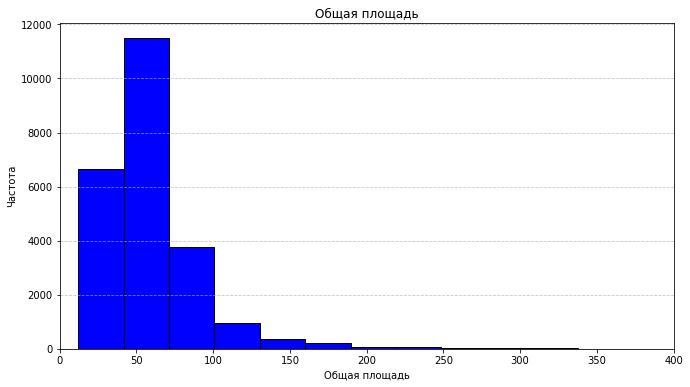

In [33]:
plot_show(data, 'total_area', 'Общая площадь')

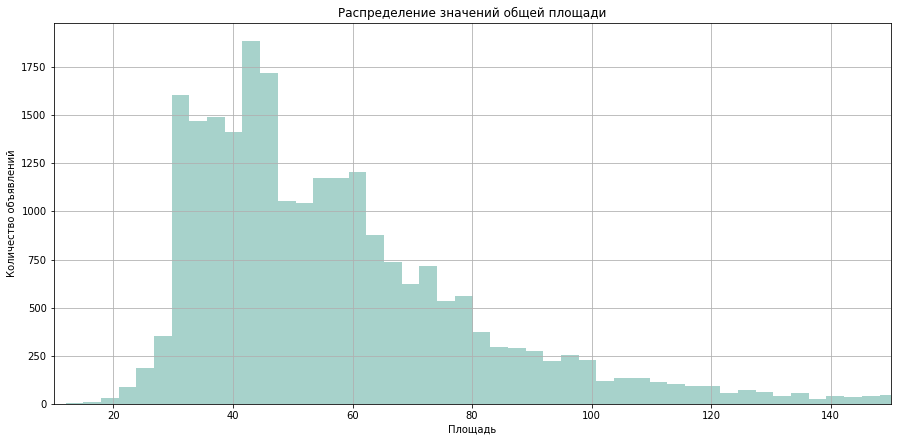

In [34]:
# код ревьюера

data['total_area'].hist(bins = 300, figsize = (15, 7), color='#A7D2CB')
plt.xlim(10, 150)

plt.title('Распределение значений общей площади')
plt.xlabel('Площадь') 
plt.ylabel('Количество объявлений')
plt.show()

In [35]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [36]:
data.sort_values(by='total_area', ascending=False).head(30).iloc[:, :-14]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name
19540,8,420000000,900.00,2017-12-06,12,2.80,25.0,409.7,25,False,False,False,112.00,0,Санкт-Петербург
12859,20,140000000,631.20,2019-04-09,7,3.90,4.0,322.3,4,False,False,False,19.50,1,Санкт-Петербург
3117,19,140000000,631.00,2019-03-30,7,2.65,5.0,NaN,5,False,False,False,60.00,0,Санкт-Петербург
15651,20,300000000,618.00,2017-12-18,7,3.40,7.0,258.0,5,False,False,False,70.00,0,Санкт-Петербург
5358,20,65000000,590.00,2019-02-14,15,3.50,6.0,409.0,3,False,False,False,100.00,0,Санкт-Петербург
4237,1,50000000,517.00,2017-10-14,7,2.65,4.0,332.0,3,False,False,False,22.00,0,Санкт-Петербург
8018,20,84000000,507.00,2015-12-17,5,4.45,7.0,301.5,7,True,False,False,45.50,1,Санкт-Петербург
5893,3,230000000,500.00,2017-05-31,6,2.65,7.0,NaN,7,False,False,False,40.00,0,Санкт-Петербург
15016,8,150000000,500.00,2016-01-13,4,3.20,7.0,NaN,7,False,False,False,NaN,0,Санкт-Петербург
12401,20,91500000,495.00,2017-06-19,7,4.65,7.0,347.5,7,False,False,False,25.00,0,Санкт-Петербург


In [37]:
new_data = data[data['total_area'] < 900] # Уберем экстраординарное значение

Оснавной пул данных с квартирами до 100 квадратных метров. А вот и самый выбивающийся выброс в 900 м², но судя по данным не вижу ничего критичного, просто ооочень большая квартира, но она сильно влияет на средние значения, вероятно стоит отказаться от нее и взять данные до 200.

#### Жилая площадь
Продолжим с жилой площадью. Данные в м².

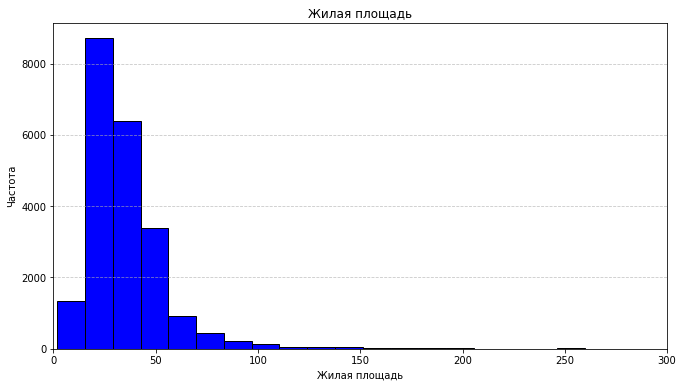

In [38]:
plot_show(new_data, 'living_area', 'Жилая площадь', 0, 300)

In [39]:
new_data['living_area'].describe()

count    21795.000000
mean        34.440636
std         21.883823
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.000000
Name: living_area, dtype: float64

In [40]:
new_data.sort_values(by='living_area', ascending=False).iloc[:, :-14]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name
5358,20,65000000,590.00,2019-02-14,15,3.50,6.0,409.0,3,False,False,False,100.0,0,Санкт-Петербург
12401,20,91500000,495.00,2017-06-19,7,4.65,7.0,347.5,7,False,False,False,25.0,0,Санкт-Петербург
4237,1,50000000,517.00,2017-10-14,7,2.65,4.0,332.0,3,False,False,False,22.0,0,Санкт-Петербург
12859,20,140000000,631.20,2019-04-09,7,3.90,4.0,322.3,4,False,False,False,19.5,1,Санкт-Петербург
660,3,49950000,483.90,2017-10-04,7,3.20,6.0,312.5,4,False,False,False,26.4,0,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23642,14,5950000,80.30,2018-07-03,3,2.70,12.0,NaN,5,False,False,False,NaN,0,Колпино
23663,12,6400000,88.00,2018-01-12,4,2.55,10.0,NaN,1,False,False,False,NaN,0,Санкт-Петербург
23670,9,2450000,45.60,2018-02-08,1,2.80,9.0,NaN,2,False,False,False,NaN,0,поселок городского типа Синявино
23679,0,2500000,35.00,2017-12-08,1,2.65,9.0,NaN,4,False,False,False,NaN,0,Сосновый Бор


In [41]:
new_data_liv_area = new_data[(new_data['living_area'] >= 5) & (new_data['living_area'] <= 200)]
new_data_liv_area.iloc[:, :-12].sort_values(by='living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest
17582,11,2680000,22.0,2018-08-11,0,2.65,25.0,5.0,8,False,True,False,NaN,2,Санкт-Петербург,22735.0,11618.0
21943,15,6100000,77.6,2019-02-28,4,2.50,9.0,5.4,1,False,False,False,9.8,0,Санкт-Петербург,29338.0,11270.0
16431,13,3799000,31.0,2018-04-12,1,2.60,5.0,6.0,1,False,False,False,17.0,0,Санкт-Петербург,32177.0,4826.0
19251,19,4050000,33.0,2018-10-15,1,2.50,22.0,6.5,21,False,False,False,18.0,0,Санкт-Петербург,9258.0,10592.0
23208,12,4800000,37.0,2016-02-24,1,2.65,14.0,8.0,11,False,False,False,22.0,0,Санкт-Петербург,27838.0,12387.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,10,55000000,280.0,2018-03-22,7,4.40,6.0,195.0,5,False,False,False,22.0,1,Санкт-Петербург,32534.0,4725.0
5042,20,35000000,380.0,2017-08-17,6,2.65,3.0,198.0,2,False,False,False,50.0,0,Пушкин,18490.0,30643.0
13397,14,19500000,309.7,2016-02-03,9,2.65,5.0,199.0,5,False,False,False,14.3,0,Санкт-Петербург,10328.0,9987.0
10246,10,25023000,253.7,2017-11-10,6,2.65,4.0,200.0,2,False,False,False,33.0,0,Санкт-Петербург,20687.0,1214.0


На основе графика можно сделать вывод что и тут (что логично) основная масса данных имеют низкие значения (примерно до 50 м²) что нам снова показывает на большее количество небольших и средних квартир. Я откинула квартиры, которые выше 200 жилых квадратных метров и меньше 5м², т.к. жилая площадь — это суммарная площадь всех жилых комнат в квартире.Даже в самых маленьких студиях жилая площадь редко бывает меньше 5 м², а значения выше 200 м² возможны только в очень редких случаях (особняки, пентхаусы), но такие объекты составляют ничтожный процент от общего объема данных.

#### Площадь кухни
Данные в м².

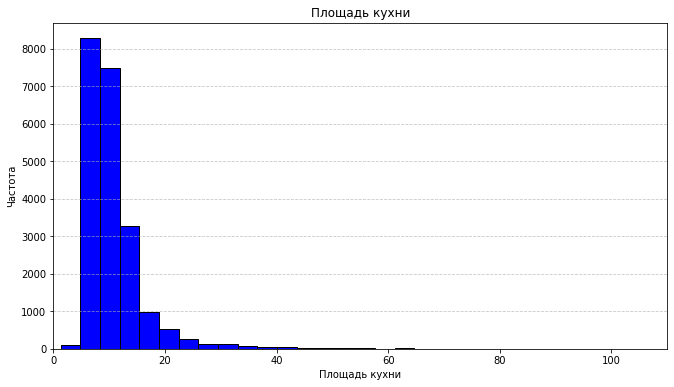

In [42]:
plot_show(new_data, 'kitchen_area', 'Площадь кухни', 0, 110)

In [43]:
new_data['kitchen_area'].describe()

count    21420.000000
mean        10.565072
std          5.864766
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

In [44]:
new_data[new_data['kitchen_area'] < 3].sort_values(by='kitchen_area', ascending=True).iloc[:, :-14]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name
20217,7,4250000,28.50,2019-05-01,1,2.80,14.0,19.5,10,False,False,False,1.30,0,Санкт-Петербург
906,15,2600000,27.00,2017-07-10,1,2.75,23.0,18.0,18,False,False,False,2.00,0,Санкт-Петербург
6262,9,3100000,24.00,2018-06-25,2,3.00,5.0,16.0,5,False,False,False,2.00,0,Санкт-Петербург
9138,17,2920000,23.29,2018-12-12,1,2.65,3.0,21.0,1,False,False,False,2.00,0,Санкт-Петербург
11033,6,5350000,32.00,2016-04-20,1,2.65,14.0,16.0,10,False,False,False,2.00,0,Санкт-Петербург
16367,2,2720000,25.70,2017-10-30,1,2.65,19.0,22.6,11,False,False,False,2.00,0,Санкт-Петербург
19642,5,1190000,14.00,2018-07-29,1,2.65,5.0,11.0,1,False,False,False,2.00,0,Санкт-Петербург
21419,4,1870000,20.00,2018-03-06,1,2.50,5.0,14.0,1,False,False,False,2.00,0,Санкт-Петербург
17834,5,2940000,34.70,2017-10-09,1,2.65,26.0,15.5,14,False,False,False,2.30,1,поселок Мурино
8729,9,2200000,18.40,2018-08-20,1,2.52,3.0,14.0,3,False,False,False,2.40,0,Пушкин


In [45]:
new_data_kitch_area = new_data[(new_data['kitchen_area'] > 3) & (new_data['kitchen_area'] < 50)]

График снова подтверждает то, что основная доля небольших и средних квартир. В данном разделе мы убрали значения кухни меньше 3х и больше 50 квадратных метров.

#### Цена объекта

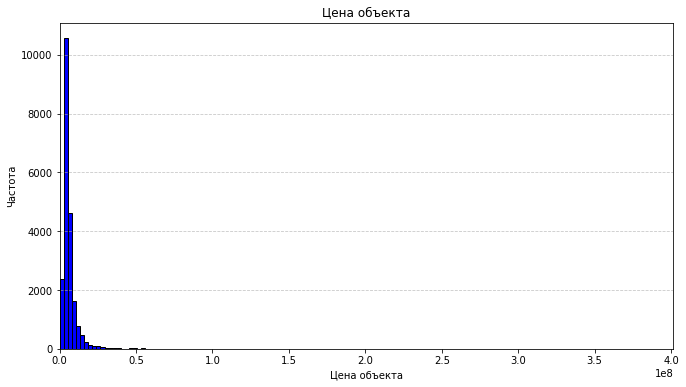

In [46]:
plot_show(new_data_kitch_area, 'last_price', 'Цена объекта', 0, 401500000, 150)

In [47]:
pd.options.display.float_format = '{:,.2f}'.format
new_data_kitch_area['last_price'].describe()

count        21,345.00
mean      6,392,790.79
std       8,567,161.80
min          12,190.00
25%       3,500,000.00
50%       4,700,000.00
75%       6,800,000.00
max     401,300,000.00
Name: last_price, dtype: float64

In [48]:
new_data_kitch_area['last_price'].dtype

dtype('int64')

In [49]:
new_data_kitch_area[new_data_kitch_area['last_price'] < 400000].iloc[:, :-14]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name
8793,7,12190,109.00,2019-03-20,2,2.75,25.00,32.00,25,False,False,False,40.50,0,Санкт-Петербург


In [50]:
new_data_kitch_area[new_data_kitch_area['last_price'] > 50000000].sort_values(by='last_price', ascending=False).head(20).iloc[:, :-14]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name
14706,15,401300000,401.00,2016-02-20,5,2.65,9.00,204.00,9,False,False,False,24.00,3,Санкт-Петербург
1436,19,330000000,190.00,2018-04-04,3,3.50,7.00,95.00,5,False,False,False,40.00,0,Санкт-Петербург
22831,18,289238400,187.50,2019-03-19,2,3.37,6.00,63.70,6,False,False,False,30.20,0,Санкт-Петербург
16461,17,245000000,285.70,2017-04-10,6,3.35,7.00,182.80,4,False,False,False,29.80,0,Санкт-Петербург
13749,7,240000000,410.00,2017-04-01,6,3.40,7.00,218.00,7,False,False,False,40.00,0,Санкт-Петербург
5893,3,230000000,500.00,2017-05-31,6,2.65,7.00,NaN,7,False,False,False,40.00,0,Санкт-Петербург
8900,13,190870000,268.00,2016-03-25,3,2.65,8.00,132.00,7,False,False,False,40.00,0,Санкт-Петербург
19865,20,180000000,347.00,2015-01-21,8,3.90,6.00,260.00,3,False,False,False,45.00,0,Санкт-Петербург
19155,20,160000000,243.00,2018-11-12,5,2.65,5.00,145.00,4,False,False,False,33.00,0,Санкт-Петербург
2536,16,159984000,242.40,2015-08-27,4,3.85,9.00,131.00,7,False,False,False,20.00,0,Санкт-Петербург


In [51]:
new_data_kitch_area[new_data_kitch_area['last_price'] < 400000].sort_values(by='last_price', ascending=False).head(20).iloc[:, :-14]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name
8793,7,12190,109.00,2019-03-20,2,2.75,25.00,32.00,25,False,False,False,40.50,0,Санкт-Петербург


Обнаружена анамалия, значение 12190 на 109 м² нереальна. Убираем ее.

In [52]:
good_data = new_data[new_data['last_price'] > 400000]

#### Количество комнат

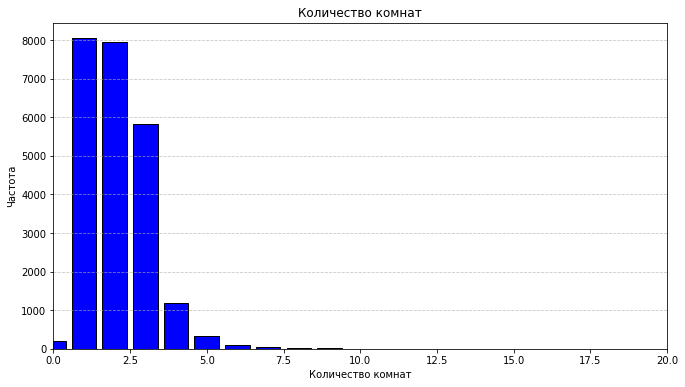

In [53]:
room_counts = good_data['rooms'].value_counts().sort_index()
plt.figure(figsize=(11, 6))
plt.bar(room_counts.index, room_counts.values, color='blue', edgecolor='black')
plt.title('Количество комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 20)
plt.show()

In [54]:
good_data['rooms'].describe()

count   23,697.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

In [55]:
good_data['rooms'].unique() # Смотрим уникальные значения

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16])

In [56]:
good_data[good_data['rooms'] > 10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_clean,price_of_one_square_meter,tdow,month_of_publication,year_of_publication,floor_type,cityCenters_nearest_km
648,3,17500000,183.70,2018-07-01,11,3.40,7.00,138.80,7,False,...,0.00,NaN,NaN,Санкт-Петербург,"95,264.02",6,7,2018,последний,3.00
866,5,25000000,363.00,2017-12-23,14,3.16,5.00,222.00,4,False,...,2.00,435.00,418.00,Санкт-Петербург,"68,870.52",5,12,2017,другой,8.00
5358,20,65000000,590.00,2019-02-14,15,3.50,6.00,409.00,3,False,...,0.00,NaN,14.00,Санкт-Петербург,"110,169.49",3,2,2019,другой,5.00
9688,8,33000000,194.10,2017-02-07,11,3.43,5.00,129.00,2,False,...,2.00,66.00,813.00,Санкт-Петербург,"170,015.46",1,2,2017,другой,1.00
14498,6,32250000,374.60,2018-06-09,19,2.65,5.00,264.50,2,False,...,2.00,548.00,114.00,Санкт-Петербург,"86,091.83",5,6,2018,другой,4.00
18848,6,28500000,270.00,2015-03-02,16,3.00,4.00,180.00,4,False,...,0.00,NaN,"1,365.00",Санкт-Петербург,"105,555.56",0,3,2015,последний,4.00
20829,6,28659000,245.40,2016-03-31,14,2.65,4.00,168.30,2,False,...,2.00,118.00,95.00,Санкт-Петербург,"116,784.84",3,3,2016,другой,2.00


In [57]:
good_data[good_data['rooms'] <= 1].sort_values(by='rooms').iloc[:, :-10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest
2563,4,3170000,28.40,2018-07-26,0,2.65,23.00,20.46,2,False,True,False,NaN,2,Санкт-Петербург,"21,460.00","16,788.00",0.00,NaN
22867,8,3090000,30.00,2017-12-17,0,2.65,25.00,18.20,5,False,True,False,NaN,0,Санкт-Петербург,"35,250.00","16,414.00",0.00,NaN
20002,8,2700000,28.00,2017-11-10,0,2.65,21.00,20.00,6,False,False,True,NaN,2,Санкт-Петербург,"21,460.00","16,788.00",0.00,NaN
946,5,2200000,23.00,2016-09-27,0,2.65,27.00,18.00,7,False,False,True,NaN,2,поселок Мурино,NaN,NaN,NaN,NaN
22877,2,4280000,28.00,2017-10-26,0,2.70,19.00,18.00,10,False,True,False,NaN,0,Санкт-Петербург,"18,982.00","7,206.00",0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7896,4,4400000,39.00,2017-09-03,1,2.65,16.00,20.00,6,False,False,False,10.00,1,Санкт-Петербург,"16,798.00","14,760.00",1.00,843.00
7894,0,4350000,36.00,2018-02-05,1,2.70,25.00,17.00,21,False,False,False,10.00,0,Санкт-Петербург,"32,822.00","11,968.00",0.00,NaN
7892,8,5800000,48.00,2018-06-23,1,2.65,25.00,NaN,19,False,False,False,NaN,0,Санкт-Петербург,"36,533.00","9,289.00",1.00,674.00
7921,1,2204000,27.55,2019-04-01,1,2.65,12.00,16.41,12,False,False,False,NaN,2,поселок Мурино,NaN,NaN,NaN,NaN


По минимальным значениям вроде аномалий нет, зато есть выбросы с квартирами больше 10 комнат. Уберем их.

In [58]:
good_data2 = good_data[good_data['rooms'] < 10]

#### Высота потолков

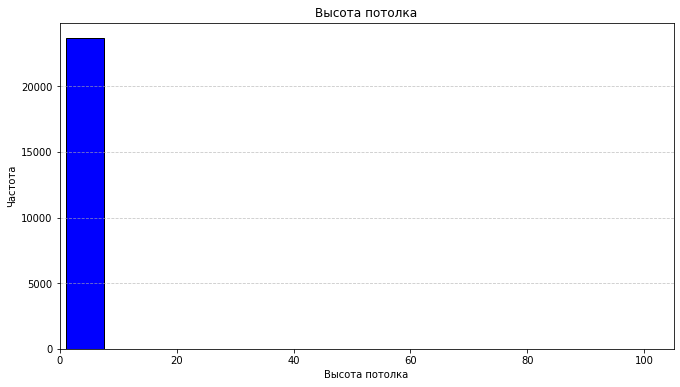

In [59]:
plot_show(good_data2, 'ceiling_height', 'Высота потолка', 0, 105, 15)

In [60]:
good_data2['ceiling_height'].describe()

count   23,687.00
mean         2.72
std          0.99
min          1.00
25%          2.60
50%          2.65
75%          2.70
max        100.00
Name: ceiling_height, dtype: float64

In [61]:
good_data2['ceiling_height'].sort_values().unique() # Смотрим уникальные значения

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,   3.5 ,
      

В значениях "14, 20,  22.6,  24,  25,  26,  27, 27.5,  32" явно ошибка при вводе. Заменим на соответствующие "1.4, 2, 2.26, 2.4, 2.5, 2.6, 2.7, 2.75, 3.2".

Посмотрим что скрывается в значении 100.

In [62]:
good_data2[good_data2['ceiling_height'] == 100].iloc[:, :-10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest
22869,0,15000000,25.00,2018-07-25,1,100.00,5.00,14.00,5,True,False,False,11.00,5,Санкт-Петербург,"34,963.00","8,283.00",1.00,223.00


Предполагаю в данном случае, должно быть 1. Заменим все что обнаружили.

In [63]:
good_data2['ceiling_height'] = good_data2['ceiling_height'].apply(lambda x: x / 10 if x > 10 and x < 100 else x)
good_data2['ceiling_height'] = good_data2['ceiling_height'].apply(lambda x: x / 100 if x == 100 else x)
good_data2['ceiling_height'].sort_values().unique()

/tmp/ipykernel_506/3040582589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_data2['ceiling_height'] = good_data2['ceiling_height'].apply(lambda x: x / 10 if x > 10 and x < 100 else x)
/tmp/ipykernel_506/3040582589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_data2['ceiling_height'] = good_data2['ceiling_height'].apply(lambda x: x / 100 if x == 100 else x)


array([1.  , 1.03, 1.2 , 1.4 , 1.75, 2.  , 2.2 , 2.25, 2.26, 2.3 , 2.34,
       2.4 , 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53, 2.54,
       2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64, 2.65,
       2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75, 2.76,
       2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87,
       2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98,
       2.99, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09,
       3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2 , 3.21,
       3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32,
       3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.42, 3.44, 3.45,
       3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53, 3.54, 3.55, 3.56,
       3.57, 3.58, 3.59, 3.6 , 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69,
       3.7 , 3.75, 3.76, 3.78, 3.8 , 3.82, 3.83, 3.84, 3.85, 3.86, 3.87,
       3.88, 3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.

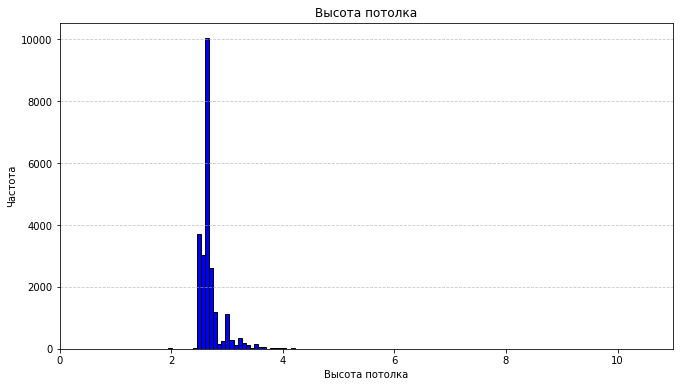

In [64]:
plot_show(good_data2, 'ceiling_height', 'Высота потолка', 0, 11, 100) # Посмотрим на новую гистограмму.

#### Этажи (первый, последний, другой)

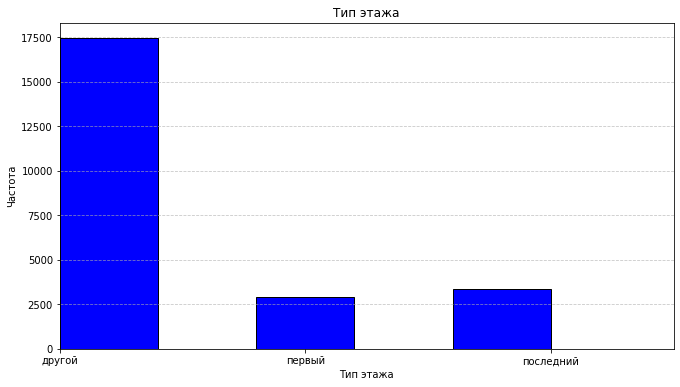

In [65]:
plot_show(good_data2, 'floor_type', 'Тип этажа', 0, 2.5, 5)

Столбец мы создавали самостоятельно, единственное что сдесь может быть аномального, это то что есть данные где не указана общая этажность дома.

В целом можно сказать что больше всего квартир не первый и не последний этаж.

#### Общее количество этажей в доме

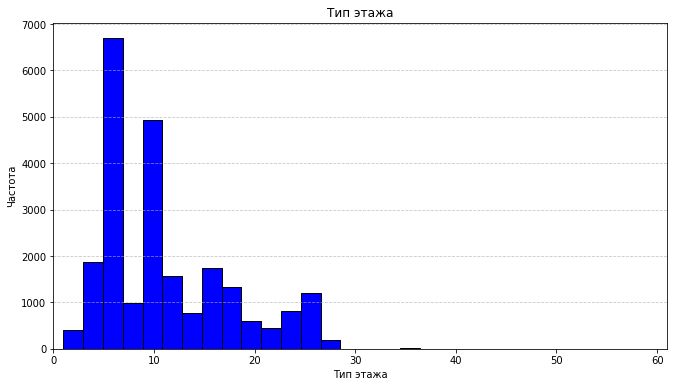

In [66]:
plot_show(good_data2, 'floors_total', 'Тип этажа', 0, 61)

In [67]:
good_data2['floors_total'].describe()

count   23,601.00
mean        10.67
std          6.60
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

In [68]:
good_data2['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60., nan])

Посмотрим что за значения 52 и 60

In [69]:
good_data2[good_data2['floors_total'] > 37].iloc[:, :-10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest
2253,12,3800000,45.50,2018-06-28,2,2.88,60.00,27.40,4,False,False,False,7.40,0,Кронштадт,"67,763.00","49,488.00",2.00,342.00
16731,9,3978000,40.00,2018-09-24,1,2.65,52.00,10.50,18,False,False,False,14.00,0,Санкт-Петербург,"20,728.00","12,978.00",1.00,793.00


Вроде ошибки, которую можно исправить, не нашлось. Уберем эти данные, т.к. являются выбросами.

In [70]:
good_data3 = good_data2[(good_data2['floors_total'] != 52) & (good_data2['floors_total'] != 60)]
good_data3['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., nan])

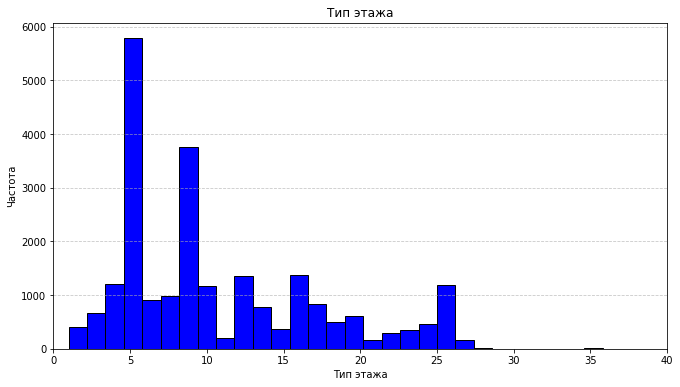

In [71]:
plot_show(good_data3, 'floors_total', 'Тип этажа', 0, 40) # Проверим что получилось

#### Расстояние до центра города в метрах


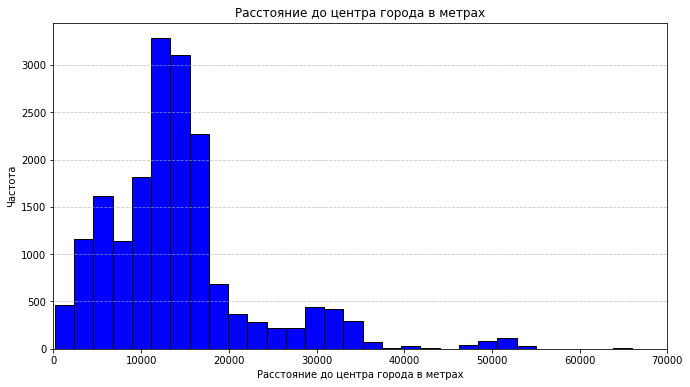

In [72]:
plot_show(good_data3, 'cityCenters_nearest', 'Расстояние до центра города в метрах', 0 , 70000)

In [73]:
good_data3['cityCenters_nearest'].describe()

count   18,166.00
mean    14,195.16
std      8,604.43
min        181.00
25%      9,238.00
50%     13,105.00
75%     16,293.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64

In [74]:
good_data3['cityCenters_nearest'].sort_values().unique()

array([  181.,   208.,   215., ..., 65952., 65968.,    nan])

In [75]:
good_data3.groupby('locality_name_clean').agg({'cityCenters_nearest': 'median'}).sort_values(by='cityCenters_nearest').head(20)

,cityCenters_nearest
locality_name_clean,
unknown,"8,943.00"
Санкт-Петербург,"12,245.00"
Парголово,"19,311.00"
Мурино,"21,888.00"
Стрельна,"23,506.00"
Шушары,"24,212.00"
Левашово,"25,727.00"
Песочный,"26,099.50"
Петро-Славянка,"27,165.00"


In [76]:
good_data3[good_data3['locality_name_clean'] == 'Санкт-Петербург'].describe().iloc[:, 10:]

,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_one_square_meter,tdow,month_of_publication,year_of_publication,cityCenters_nearest_km
count,"15,623.00","15,647.00","15,647.00","7,275.00","15,647.00","7,976.00","13,627.00","15,708.00","15,708.00","15,708.00","15,708.00","15,647.00"
mean,"28,048.98","11,605.91",0.63,498.53,0.77,520.39,182.71,"114,841.37",2.56,6.42,"2,017.35",11.60
std,"11,559.75","4,840.30",0.79,345.31,0.92,280.27,224.49,"52,517.26",1.78,3.47,1.06,4.86
min,0.00,181.00,0.00,1.00,0.00,13.00,1.00,"15,345.27",0.00,1.00,"2,014.00",0.00
25%,"18,578.00","8,340.00",0.00,295.00,0.00,293.00,42.00,"90,909.09",1.00,3.00,"2,017.00",8.00
50%,"26,765.00","12,245.00",0.00,460.00,1.00,503.00,95.00,"104,766.08",2.00,6.00,"2,017.00",12.00
75%,"36,614.00","14,944.50",1.00,619.00,1.00,738.25,231.00,"124,440.04",4.00,10.00,"2,018.00",15.00
max,"54,784.00","29,493.00",3.00,"3,190.00",3.00,"1,337.00","1,572.00","1,907,500.00",6.00,12.00,"2,019.00",29.00


In [77]:
good_data3[good_data3['locality_name_clean'] == 'unknown'].iloc[:, 10:]

,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_clean,price_of_one_square_meter,tdow,month_of_publication,year_of_publication,floor_type,cityCenters_nearest_km
1097,False,False,8.80,0,unknown,"23,478.00","4,258.00",0.00,NaN,0.00,NaN,147.00,unknown,"105,263.16",4,4,2016,другой,4.00
2033,False,False,18.60,0,unknown,NaN,NaN,NaN,NaN,NaN,NaN,34.00,unknown,"67,475.00",1,5,2017,другой,NaN
2603,False,False,10.70,0,unknown,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,276.00,unknown,"78,495.67",6,9,2015,другой,17.00
2632,False,False,8.20,0,unknown,"22,041.00","17,369.00",0.00,NaN,1.00,374.00,256.00,unknown,"82,221.04",6,10,2015,другой,17.00
3574,False,False,6.50,0,unknown,"27,419.00","8,127.00",0.00,NaN,1.00,603.00,45.00,unknown,"90,322.58",5,5,2016,последний,8.00
4151,False,False,13.38,0,unknown,"25,054.00","3,902.00",1.00,485.00,3.00,722.00,869.00,unknown,"196,648.04",1,12,2014,другой,4.00
4189,False,False,10.40,0,unknown,"21,774.00","3,039.00",1.00,690.00,1.00,953.00,223.00,unknown,"115,000.00",3,12,2015,другой,3.00
4670,False,False,NaN,0,unknown,"26,534.00","5,382.00",1.00,446.00,1.00,376.00,350.00,unknown,"66,265.06",4,8,2015,другой,5.00
5343,False,False,8.30,4,unknown,"10,556.00","9,538.00",1.00,67.00,0.00,NaN,303.00,unknown,"158,362.57",2,1,2016,другой,10.00
5707,False,False,NaN,0,unknown,"21,460.00","16,788.00",0.00,NaN,1.00,170.00,49.00,unknown,"123,333.33",4,4,2016,другой,17.00


Все значения в столбце cityCenters_nearest у города unknown, если не пустые, то меньше медианы по Санкт-Петербургу. Поэтому заменим данные с unknown на Санкт-Петербург там, где известно расстояние до центра.

In [78]:
good_data3.loc[
    (new_data['locality_name'] == 'unknown') & (new_data['cityCenters_nearest'].notna()), 'locality_name'
] = 'Санкт-Петербург'
good_data3.loc[
    (new_data['locality_name_clean'] == 'unknown') & (new_data['cityCenters_nearest'].notna()), 'locality_name_clean'
] = 'Санкт-Петербург'
good_data3.groupby('locality_name_clean').agg({'cityCenters_nearest': 'median'}).sort_values(by='cityCenters_nearest').head(20)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,cityCenters_nearest
locality_name_clean,
Санкт-Петербург,"12,244.50"
Парголово,"19,311.00"
Мурино,"21,888.00"
Стрельна,"23,506.00"
Шушары,"24,212.00"
Левашово,"25,727.00"
Песочный,"26,099.50"
Петро-Славянка,"27,165.00"
Александровская,"27,468.00"


In [79]:
good_data3[good_data3['locality_name_clean'] == 'unknown']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_clean,price_of_one_square_meter,tdow,month_of_publication,year_of_publication,floor_type,cityCenters_nearest_km
2033,6,5398000,80.00,2017-05-30,3,2.65,4.00,42.60,2,False,...,NaN,NaN,34.00,unknown,"67,475.00",1,5,2017,другой,NaN
14342,3,3611000,53.50,2017-04-27,1,2.65,4.00,25.80,3,False,...,NaN,NaN,92.00,unknown,"67,495.33",3,4,2017,другой,NaN
17535,2,5985000,79.80,2018-07-30,3,2.65,9.00,NaN,2,False,...,NaN,NaN,213.00,unknown,"75,000.00",0,7,2018,другой,NaN
20382,8,1750000,72.90,2018-10-27,3,2.65,5.00,47.30,2,False,...,NaN,NaN,NaN,unknown,"24,005.49",5,10,2018,другой,NaN
20590,7,3380000,56.00,2017-11-06,2,2.70,4.00,29.00,3,False,...,NaN,NaN,78.00,unknown,"60,357.14",0,11,2017,другой,NaN
21715,2,6047550,80.10,2018-07-30,2,2.65,9.00,30.50,2,False,...,NaN,NaN,176.00,unknown,"75,500.00",0,7,2018,другой,NaN
21898,2,5886750,83.50,2018-07-30,2,2.65,9.00,36.60,2,False,...,NaN,NaN,169.00,unknown,"70,500.00",0,7,2018,другой,NaN
22717,9,3000000,35.00,2018-01-02,1,2.60,16.00,16.00,7,False,...,NaN,NaN,75.00,unknown,"85,714.29",1,1,2018,другой,NaN


Осталось только 6 значений.

#### Расстояние до ближайшего парка

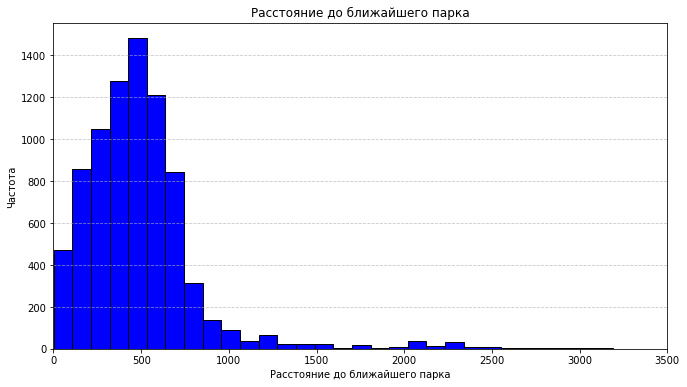

In [80]:
plot_show(good_data3, 'parks_nearest', 'Расстояние до ближайшего парка', 0, 3500)

In [81]:
good_data3['parks_nearest'].describe()

count   8,069.00
mean      490.75
std       342.45
min         1.00
25%       288.00
50%       455.00
75%       612.00
max     3,190.00
Name: parks_nearest, dtype: float64

In [82]:
good_data3.groupby('locality_name_clean').agg({'parks_nearest': 'median'}).sort_values(by='parks_nearest').head(15)

,parks_nearest
locality_name_clean,
Зеленогорск,147.50
Кронштадт,289.50
Петергоф,294.00
Павловск,312.00
Сестрорецк,367.00
Колпино,393.00
Пушкин,399.50
Ломоносов,407.00
Красное Село,428.50


Очень много незаполненных значений. Изменить тут кажется ничего не получится.

#### Как быстро продавались квартиры (столбец days_exposition). 

Этот параметр показывает, сколько дней было размещено каждое объявление.

1. Построим гистограмму.

2. Посчитаем среднее и медиану.

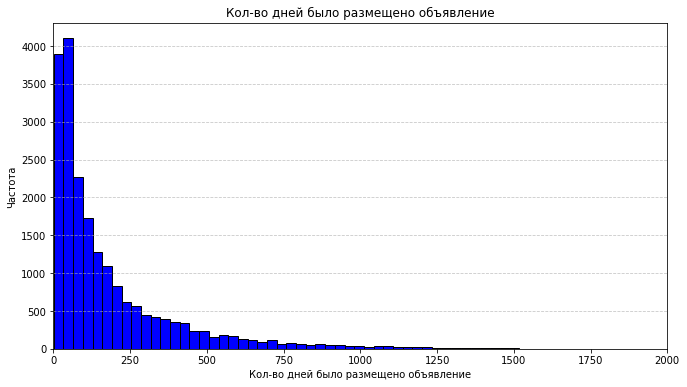

In [83]:
plot_show(good_data3, 'days_exposition', 'Кол-во дней было размещено объявление', 0, 2000, 50)

In [84]:
good_data3['days_exposition'].isnull().sum()

3179

In [85]:
good_data3['days_exposition'].describe()

count   20,506.00
mean       180.84
std        219.57
min          1.00
25%         45.00
50%         95.00
75%        232.00
max      1,580.00
Name: days_exposition, dtype: float64

Среднее время продажи: приблизительно 181 день.

Медианное время продажи: 95 дней.

##### Итого

Учитывая очень большой разброс данных, то лучше ориентироваться на медианное значение. То есть в среднем продажа квартиры занимает 102 дня.

Быстрой продажей будет до 45 дней (25% основного пула данных), а долгой от 232 дней (75% основного пула данных).

#### «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». 

Построены графики, которые показывают зависимость цены от параметров:
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - количество комнат;
  - тип этажа, на котором расположена квартира (первый, последний, другой);
  - дата размещения (день недели, месяц, год)

Для корректности изображения графиков переведем цену в миллионы.

In [86]:
good_data4 = good_data3.copy()

In [87]:
good_data4['price_mln'] = good_data4['last_price'] / 1000000

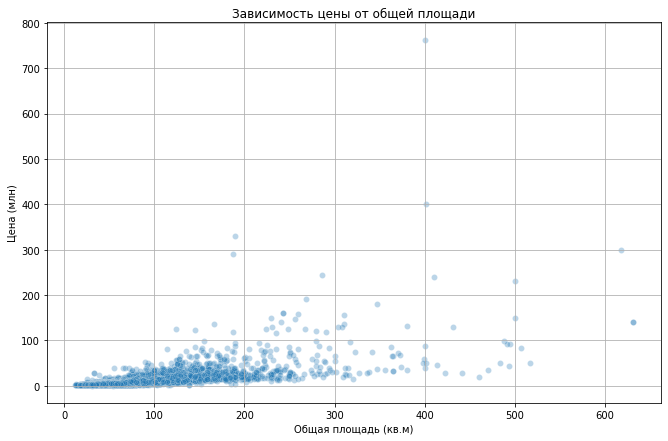

In [88]:
# Зависимость цены от общей площади
plt.figure(figsize=(11, 7))
sns.scatterplot(data=good_data4, x='total_area', y='price_mln', alpha=0.3)
plt.title('Зависимость цены от общей площади')
plt.xlabel('Общая площадь (кв.м)')
plt.ylabel('Цена (млн)')
plt.grid(True)
plt.show()

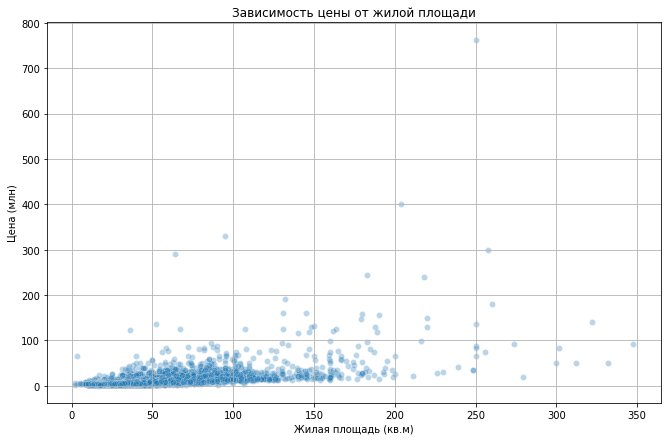

In [89]:
# Зависимость цены от жилой площади
plt.figure(figsize=(11, 7))
sns.scatterplot(data=good_data4, x='living_area', y='price_mln', alpha=0.3)
plt.title('Зависимость цены от жилой площади')
plt.xlabel('Жилая площадь (кв.м)')
plt.ylabel('Цена (млн)')
plt.grid(True)
plt.show()

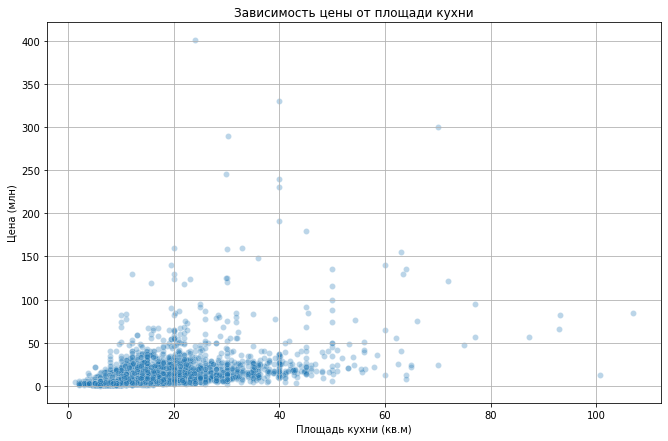

In [90]:
# Зависимость цены от площади кухни
plt.figure(figsize=(11, 7))
sns.scatterplot(data=good_data4, x='kitchen_area', y='price_mln', alpha=0.3)
plt.title('Зависимость цены от площади кухни')
plt.xlabel('Площадь кухни (кв.м)')
plt.ylabel('Цена (млн)')
plt.grid(True)
plt.show()

Общая тенденция 3х предыдущих графиков - чем больше площадь, тем выше цена объекта, однако, есть и разброс по данным в пределах площади.

**Вывод по общей, жилой площади и кухни**

Общая площадь состоит из жилой и кухонной площади, они все влияют на цену объекта.

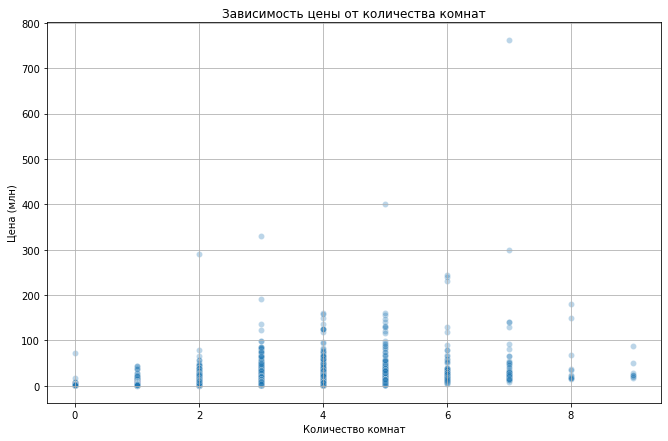

In [91]:
# Зависимость цены от количества комнат
plt.figure(figsize=(11, 7))
sns.scatterplot(data=good_data4, x='rooms', y='price_mln', alpha=0.3)
plt.title('Зависимость цены от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена (млн)')
plt.grid(True)
plt.show()

Чем больше количество комнат, тем выше цена объекта (до 5 комнат, дальше данных маловато). Однако имеется значительный разброс данных.

**Вывод**

Количество комнат влияет на цену объекта.

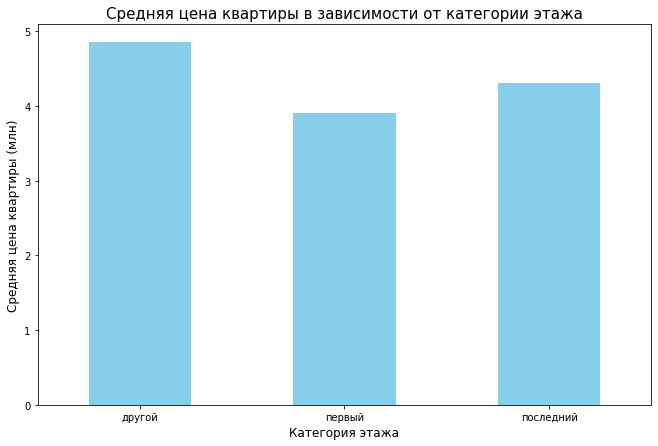

In [92]:
# Зависимость цены от типа этажа
good_data4.groupby('floor_type')['price_mln'].median().plot(kind='bar', figsize=(11, 7), color='skyblue')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от категории этажа', size=15)
plt.xlabel('Категория этажа', size=12)
plt.ylabel('Средняя цена квартиры (млн)', size=12)

plt.show()

Квартиры на других этажах ("не первый" и "не последний") имеют самую высокую среднюю цену.

Квартиры на последних этажах имеют вторую по величине среднюю цену.

Квартиры на первых этажах имеют самую низкую среднюю цену.

**Вывод**

Категория этажа влияет на стоимость квартиры: квартиры на других этажах стоят дороже, чем на первых или последних этажах. Однако разница в средней цене между этажами не является огромной, что указывает на то, что этаж — это один из факторов, но не определяющий.

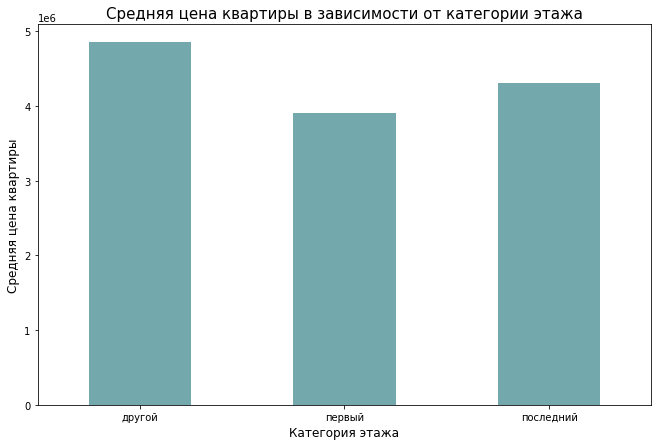

In [93]:
# код ревьюера

good_data4.groupby('floor_type')['last_price'].median().plot(kind='bar', figsize=(11, 7), color='#73A9AD')

plt.xticks(rotation=0)
plt.title('Средняя цена квартиры в зависимости от категории этажа', size=15)
plt.xlabel('Категория этажа', size=12)
plt.ylabel('Средняя цена квартиры', size=12)

plt.show()

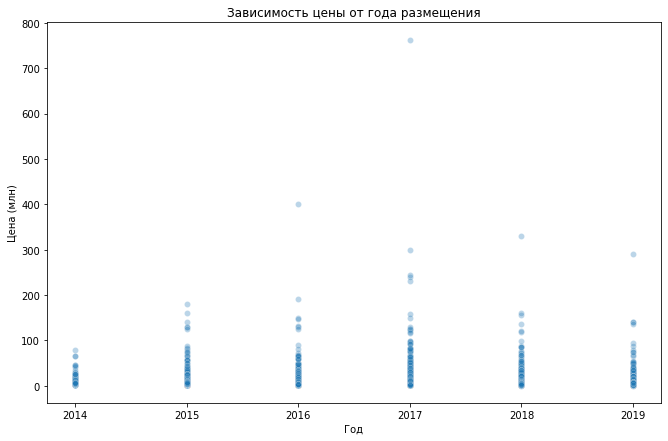

In [94]:
# Зависимость цены от даты размещения (год)
plt.figure(figsize=(11, 7))
sns.scatterplot(data=good_data4, x='year_of_publication', y='price_mln', alpha=0.3)
plt.title('Зависимость цены от года размещения')
plt.xlabel('Год')
plt.ylabel('Цена (млн)')
plt.show()

В 2014 году средние цены были низкими. В 2015–2017 годах цены стали выше, с максимальной ценой в 2017 году

**Вывод**

Год размещения объявления имеет некоторое влияние на цену объекта (скорее всего связано с экономикой в стране).

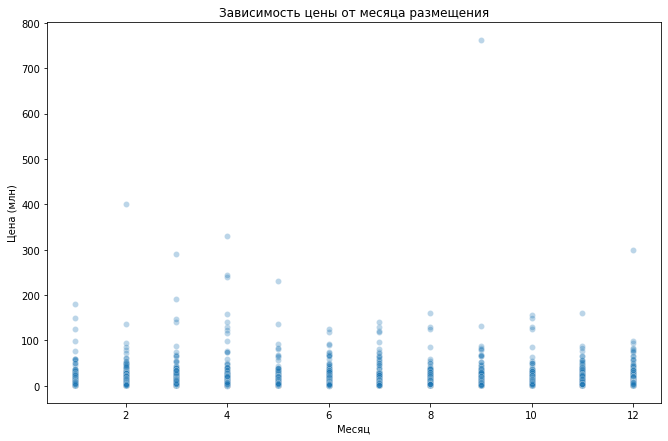

In [95]:
# Зависимость цены от даты размещения (месяц)
plt.figure(figsize=(11, 7))
sns.scatterplot(data=good_data4, x='month_of_publication', y='price_mln', alpha=0.3)
plt.title('Зависимость цены от месяца размещения')
plt.xlabel('Месяц')
plt.ylabel('Цена (млн)')
plt.show()

Цены на объекты недвижимости не имеют четкой зависимости от месяца размещения объявления. Разброс цен значителен для каждого месяца.

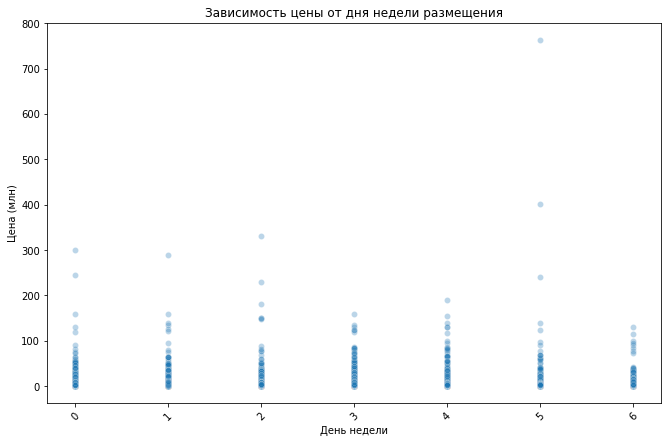

In [96]:
# Зависимость цены от даты размещения (день недели)
plt.figure(figsize=(11, 7))
sns.scatterplot(data=good_data4, x='tdow', y='price_mln', alpha=0.3)
plt.title('Зависимость цены от дня недели размещения')
plt.xlabel('День недели')
plt.ylabel('Цена (млн)')
plt.xticks(rotation=45)
plt.show()

Цены на объекты недвижимости не имеют четкой зависимости от дня недели размещения объявления.

#### Cредняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
Постройте сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.


In [97]:
grouped_data = good_data4.groupby('locality_name_clean').agg( # Группировка данных
    count_ads=('price_of_one_square_meter', 'size'),  # Количество объявлений
    avg_price_of_one_square_meter=('price_of_one_square_meter', 'mean')  # Средняя цена за квадратный метр
).reset_index()

top_10_localities = grouped_data.sort_values(by='count_ads', ascending=False).reset_index().head(10) # Выбор топ-10 населенных пунктов с наибольшим количеством объявлений
top_10_localities.columns = ['Индекс', 'Населенный пункт', 'Кол-во квартир', 'Средняя цена за квадратный метр']
top_10_localities.sort_values(by='Средняя цена за квадратный метр', ascending=False)

,Индекс,Населенный пункт,Кол-во квартир,Средняя цена за квадратный метр
0,223,Санкт-Петербург,15749,"114,802.43"
5,202,Пушкин,369,"103,125.82"
2,106,Кудрово,472,"95,324.93"
7,170,Парголово,327,"90,175.91"
1,146,Мурино,590,"86,087.51"
3,297,Шушары,440,"78,677.36"
6,89,Колпино,338,"75,424.58"
8,43,Гатчина,307,"68,746.15"
4,35,Всеволожск,398,"68,654.47"
9,36,Выборг,237,"58,141.91"


Больше всего продаж было в Санкт-Петербурге, по остальным данных намного меньше.

Самый дорогой квадратный метр в Санкт-Петербурге (114,802.43). Самый дешевый в Выборге (58,141.91).

Хм, достаточно логично, ведь Санкт-Петербург культурная столица и большой город.

#### Рассчет по Санкт-Петербургу
Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите их среднюю стоимость на разном удалении от центра. Учитывайте каждый километр расстояния: узнайте среднюю цену квартир в одном километре от центра, в двух и так далее. Опишите, как стоимость объектов зависит от расстояния до центра города — постройте график изменения средней цены для каждого километра от центра Петербурга.

In [98]:
spb_data = good_data4[good_data4['locality_name'] == 'Санкт-Петербург'].copy() # Отсортировали данные по городу и сохранили копию в перепенную


In [99]:
# Группируем по расстоянию и вычисляем среднюю цену
price_by_distance = spb_data.groupby('cityCenters_nearest_km')['price_mln'].mean().reset_index() 
# Переименовываем столбцы для удобства
price_by_distance.columns = ['Расстояние в км', 'Средняя цена в млн'] 
price_by_distance['Средняя цена в млн'] = price_by_distance['Средняя цена в млн'].map('{:,.2f}'.format)
price_by_distance.head(10)

,Расстояние в км,Средняя цена в млн
0,0.00,31.45
1,1.00,21.10
2,2.00,17.77
3,3.00,11.08
4,4.00,13.22
5,5.00,14.38
6,6.00,15.34
7,7.00,14.78
8,8.00,9.22
9,9.00,6.95


Данные готовы, построим график "как стоимость объектов зависит от расстояния до центра города".

In [103]:
price_by_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Расстояние в км     32 non-null     float64
 1   Средняя цена в млн  32 non-null     float64
dtypes: float64(2)
memory usage: 640.0 bytes


In [101]:
price_by_distance['Средняя цена в млн'] = pd.to_numeric(price_by_distance['Средняя цена в млн'], errors='coerce')

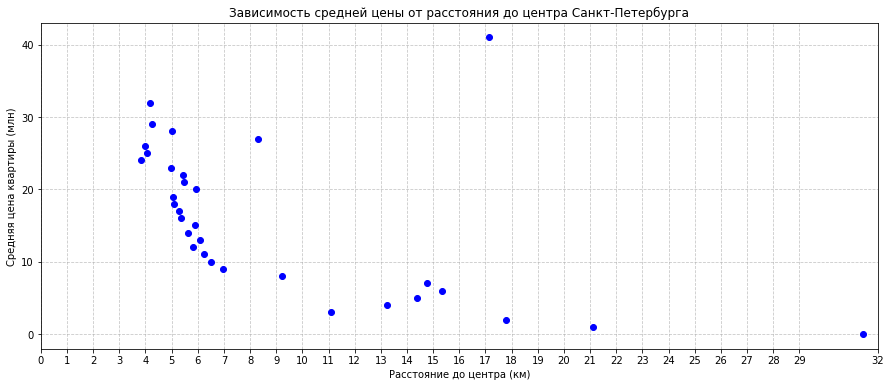

In [102]:
plt.figure(figsize=(15, 6))
plt.plot(price_by_distance['Средняя цена в млн'], price_by_distance['Расстояние в км'], marker='o', linestyle='None', color='b')
plt.title('Зависимость средней цены от расстояния до центра Санкт-Петербурга')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена квартиры (млн)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(price_by_distance['Расстояние в км'])  # Устанавливаем метки для каждого километра
plt.xlim(0, 32)
plt.show()

Средняя цена квартиры снижается с увеличением расстояния до центра города. Это указывает на то, что квартиры ближе к центру стоят дороже, а чем дальше от центра, тем дешевле объекты.

- Наиболее высокие цены наблюдаются для квартир, расположенных вблизи центра (приблизительно менее 5 км).
- Средние цены встречаются на расстоянии 5–7 км от центра.
- Дешевые квартиры (до 5 млн) находятся на значительном удалении от центра (встречаются от 13 км, а основной пулл будет после 16 км).

Расположение квартиры играет ключевую роль в формировании её стоимости: чем ближе к центру, тем выше цена. Однако есть исключения, связанные с другими факторами.

### Напишите общий вывод

#### Предобработка данных
##### Пропуски значений
ceiling_height           9195 Заполнены медианным значением

floors_total               86 Не получится высчитать.

living_area              1903 Не получится высчитать, т.к. нет данных о размерах коридоров и санузлов.

is_apartment            20924 Заполнено False, т.к. считаю что если поле не заполнено, то апартаментами квартиры не являются.

kitchen_area             2278 Не получится высчитать, т.к. нет данных о размерах коридоров и санузлов.

balcony                 11519 Заполненно 0, т.к. скорее всего если поле не заполнено, то балконов в квартире нет.

locality_name              49 Часть заполнена как "неизвестно", а часть была заполнена медианой по совпадению с геоданных (расстояние до центра).

airports_nearest         5542 Не получится заполнить. Данные будут недостоверными.

cityCenters_nearest      5519 Не получится заполнить. Данные будут недостоверными.

parks_around3000         5518 Не получится заполнить. Данные будут недостоверными.

parks_nearest           15620 Не получится заполнить. Данные будут недостоверными.

ponds_around3000         5518 Не получится заполнить. Данные будут недостоверными.

ponds_nearest           14589 Не получится заполнить. Данные будут недостоверными.

days_exposition          3181 Не получится заполнить. Данные будут недостоверными. Не хватает информации по данному полю, скорее всего оно пустое, т.к. еще не снято объявление о продаже.

**Общее**

Пропуски в данных, собранных от людей, скорее всего, из-за того, что поля не обязательны или у пользователей нет данных. Что касаемо данных «Аппартаменты» и подобных, то, скорее всего, не заполнено, потому что пользователи посчитали, если не является аппартаментами, то и заполнять данное поле не обязательно.

Пропуски в данных, собранных автоматически, подозрительно совпадают, скорее всего, не удалось распознать расположение.

Конечно, никогда не исключаем технические ошибки при сборе данных.

##### Типы данных в столбцах

Были изменены типы данных, такие как время (first_day_exposition), для дальнейшего анализа нам нужно будет «вытягивать» данные, например, по месяцу. Были переведены в целочисленный тип там, где не может быть итого, например, «Этажность дома». Еще изменен тип на булево значение в столбце «Аппартаменты», т.к. значения True/False и их было бы удобно использовать в дальнейшем анализе.

##### Неявные дубликаты

Данные взяты только по Санкт-Петербургу и соседних населённых пунктах, поэтому для исключения дубликатов при дальнейшем анализе был создан столбец locality_name_clean, в котором нет упоминаний общих слов («поселок», «посёлок», «село» и т. д.), остались только уникальные названия (было:331, осталось: 306).

#### Добавление столбцов

Для дальнейшего анализа были добавлены столбцы:
1. Цена одного квадратного метра
2. День недели публикации объявления
3. Месяц публикации объявления
4. Год публикации объявления
5. Тип этажа квартиры (первый, последний, другой)
6. Расстояние до центра города в км

#### Исследовательский анализ данных

Исследованы и вычлененны ошибки в данных и удалены выбросы значений по столбцам:
1. Общая площадь
2. Жилая площадь
3. Площадь кухни
4. Цена объекта
5. Количество комнат
6. Высота потолков
7. Этажность (первый, последний, другое)
8. Общее кол-во этажей в доме
9. Расстояние до центра города в метрах
10. Расстояние до ближайшего парка

Среднестатистическая квартира будет двухкомнатной, в 52 кв. м. ( 30 жилая, 9.1 кухня) не на первом и не на последнем этаже, примерно за 4,7 млн.

##### Доп. вопросы
**1. Как быстро продавались квартиры**

Среднее время продажи: приблизительно 181 день.

Медианное время продажи: 95 дней.

Диаграмма скошена вправо, поэтому при вопросах по типу "быстро продали или медленно" необходимо ориентироваться на медиану (95 дней).

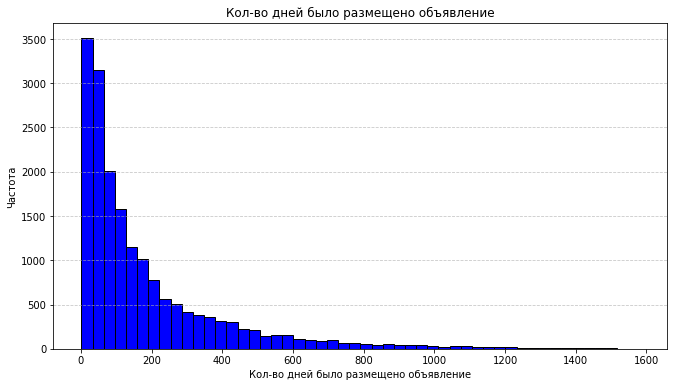

**2. Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта**

Цена объекта недвижимости зависит от множества факторов, среди которых площадь, количество комнат, район, состояние объекта, тип недвижимости, этаж, виды из окон и другие характеристики. Однако эти параметры сами по себе не являются определяющими.

Если отвечать на поставленный вопрос из того набора данных, то площадь влияет на стоимость объекта. Самые популярные квартиры 3-5 комнат (скорее всего запрос именно от семей с детьми). Также наблюдается рост цен по 2017 год, далее снижение цены до 2019 (думаю здесь экономика влияет).

Краткий вывод: Чтобы точно оценить стоимость объекта, нужно учитывать не только площадь, количество комнат и этаж, но и другие факторы, такие как район, состояние объекта, время размещения объявления и особенности окружающей среды. Просто площадь или этаж — это лишь часть картины.

**3. Средняя цена одного квадратного метра**

Постройте сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.

Топ 10 населенных пунктов  и его цена за квадратный метр:
1. Санкт-Петербург 113074.754555
2. Пушкин 103028.94
3. Кудрово 95349.59
4. Парголово 90756.00
5. Мурино 85661.89
6. Петергоф 83754.20
7. Шушары 78535.19
8. Колпино 75226.3
9. Всеволожск 69029.15
10. Гатчина 68635.62

**Вывод**

Больше всего продаж было в Санкт-Петербурге (15749), по остальным данных намного меньше ( < 500).

Самый дорогой квадратный метр в Санкт-Петербурге (114,802.43). Самый дешевый в Выборге (58,141.91).

Хм, достаточно логично, ведь Санкт-Петербург культурная столица и большой город.

**3. Рассчет по Санкт-Петербургу**

Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите их среднюю стоимость на разном удалении от центра. Учитывайте каждый километр расстояния: узнайте среднюю цену квартир в одном километре от центра, в двух и так далее. Опишите, как стоимость объектов зависит от расстояния до центра города — постройте график изменения средней цены для каждого километра от центра Петербурга.

| Расстояние в км | Средняя цена    |
|-----------------|----------------|
| 0.0             | 28,470,553.65  |
| 1.0             | 20,359,114.78  |
| 2.0             | 16,489,890.80  |
| 3.0             | 10,522,553.66  |
| 4.0             | 11,471,277.47  |
| 5.0             | 11,994,267.84  |
| 6.0             | 13,679,051.50  |
| 7.0             | 13,769,694.19  |
| 8.0             | 9,381,110.63   |
| 9.0             | 6,953,025.03   |

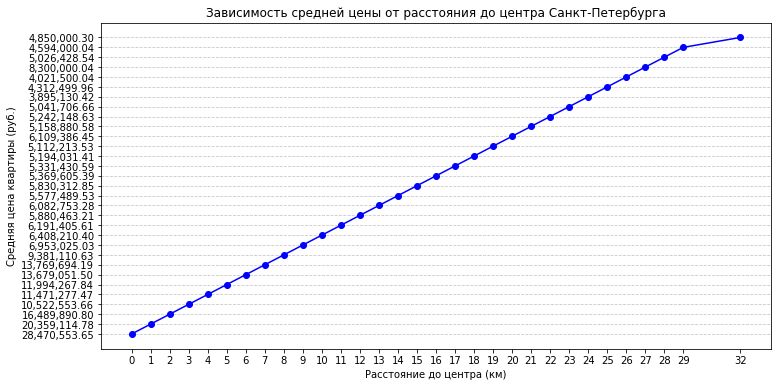

**Вывод**

Чем дальше от центра тем дороже, особенно интересно что от 7 км от центра цена резко понижается.

#### Общий вывод

Данные показывают, что наибольшее кол-во объявлений было про малые и средние квартиры. Экстраординарных было крайне мало.

Самые дорогие квартиры в Санкт-Петербурге и в Пушкине, а самые дешевые в Всеволожске и Гатчине. 

Самые быстрые продажи те, которые до 45 дней, далее средняя скорость, а медленными можно считать от 239 дней (что соответсвует 25%, 50%, 75% данных согласно статистике).


**Рекомендации**
Для уменьшения пропусков значений, добавить обязательность заполнения полей. При сборе геоданных необходимо посмотреть, чаще там где не вычислен населенный пункт, там нет и других данных.